# Test of Forel Ule on satellite images

Test images used in WW2015 and W2016:
* ENVISAT_MERIS_RR.20060504T100254.L2.OC.nc
* AQUA_MODIS.20060504T115501

S3 image of LiverpoolBay
* S3A_OL_20200506T104005_20200506T104305_20200507T143731_0179_058_051_1980_LN1_O_NT_002' (processed with Polymer)
* S3A_OL_2_WFR____20200506T104005_20200506T104305_20200507T211159_0179_058_051_1980_MAR_O_NT_002 (L2 from EUMETSAT)

**References**

*Wernand, M. R., Hommersom, a., & Van Der Woerd, H. J. (2013). MERIS-based ocean colour classification with the discrete Forel-Ule scale. Ocean Science, 9, 477–487.* doi:10.5194/os-9-477-2013

*Van der Woerd, H. J., Wernand, M., Peters, M., Bala, M., and Brockmann, C. 2016. True color analysis of natural waters with SeaWiFS, MODIS, MERIS and OLCI by SNAP. In Proceedings of the Ocean Optics XXIII, Victoria, BC, Canada, pp. 23–28.*

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import fume

In [4]:
polymersmallfile='data/S3A_OL_1_EFR____20200203T105112_20200203T105412_20200204T152758_0179_054_265_1980_LN1_O_NT_002.polymer.thewash.nc'

In [5]:
bands_meris={'red':'Rrs_665','green':'Rrs_560','blue':'Rrs_443'}
bands_modis={'red':'Rrs_667','green':'Rrs_555','blue':'Rrs_443'}
bands_olci={'red':'Rw665','green':'Rw560','blue':'Rw443'}
bands_olci_eumetsat={'red':'Oa03_reflectance','green':'Oa06_reflectance','blue':'Oa08_reflectance'}


## Auxiliary plotting functions 

In [47]:
def plot_rgb_image(ax, imgfile,bands,rcextent):
    
    rstep,cstep=(1,1)
    ri,rf,ci,cf = rcextent
    if ri>rf:
        rstep=-1
    if ci>cf:
        cstep=-1
    
    try:
        img = xr.open_dataset(imgfile,group='geophysical_data')
    except OSError:
        img = xr.open_dataset(imgfile)
        
    redb=bands['red']
    greenb=bands['green']
    blueb=bands['blue']

    #fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10,8))
    #ax=axs
    print(img[redb].shape)
    try:
        # for meris images
        rgb = xr.concat([img[redb][ri:rf:rstep,ci:cf:cstep], 
                         img[greenb][ri:rf:rstep,ci:cf:cstep],
                         img[blueb][ri:rf:rstep,ci:cf:cstep]
                        ],
                         dim='rgb').transpose('number_of_lines', 'pixels_per_line','rgb')
    except ValueError:
        try:
            # for olci images
            rgb = xr.concat([img[redb][ri:rf:rstep,ci:cf:cstep], 
                             img[greenb][ri:rf:rstep,ci:cf:cstep],
                             img[blueb][ri:rf:rstep,ci:cf:cstep]
                            ],
                             dim='rgb').transpose('height', 'width','rgb')
        except ValueError:
            # for olci EUMETSAT images
            rgb = xr.concat([img[redb][ri:rf:rstep,ci:cf:cstep], 
                             img[greenb][ri:rf:rstep,ci:cf:cstep],
                             img[blueb][ri:rf:rstep,ci:cf:cstep]
                            ],
                             dim='rgb').transpose('y', 'x','rgb')
    
    ax.imshow(rgb/rgb.quantile(0.95),interpolation='none')
        
    return ax

In [33]:
def plot_fu_image(ax, imgfile,reflectance_prefix,rcextent,sensorcorr):

    rstep,cstep=(1,1)
    
    ri,rf,ci,cf = rcextent
    if ri>rf:
        rstep=-1
    if ci>cf:
        cstep=-1    

    try:
        img = xr.open_dataset(imgfile,group='geophysical_data')
    except OSError:
        img = xr.open_dataset(imgfile)

    # Extract wavelengths from band names
    wavelength = []
    bandid = []
    for var in img.data_vars:
        if reflectance_prefix in var:
            bandid.append(var)
            try:
                wavelength.append( int ( var.replace(reflectance_prefix,'') ) )
            except ValueError: 
                wavelength.append( float(img[var].attrs['radiation_wavelength']) )

    # Create a 3-D array along wavelength dimension
    Rw = xr.concat( [img[id][ri:rf:rstep,ci:cf:cstep] for id in bandid] ,dim='wavelength')
    #Rw.name = 'Rw'
    Rw = Rw.assign_coords(wavelength=wavelength)


    # Calculate and plot Forel-Ule classes
    fu,_ = fume.calc_ForelUle_image(Rw.coords['wavelength'].values, 
                                    Rw,
                                    sensorcorr=sensorcorr,
                                    fucalibration='data/hue_angle_limits_NWW2013.csv')
        
    #plt.subplots(nrows=1,ncols=1,figsize=(10,8))
    mapp = ax.imshow(fu, cmap=fume.forelulecmap(),vmin=0.5,vmax=21.5,interpolation='none')
    cbar = plt.colorbar(mapp, ax=ax)
    cbar.set_ticks(range(1,21+1))
    cbar.set_ticklabels(range(1,21+1))
    cbar.set_label('Forel Ule classes')

    return ax,fu

In [34]:
def plot_ha_image(ax,imgfile,reflectance_prefix,rcextent,sensorcorr):

    rstep,cstep=(1,1)
    
    ri,rf,ci,cf = rcextent
    if ri>rf:
        rstep=-1
    if ci>cf:
        cstep=-1    

    try:
        img = xr.open_dataset(imgfile,group='geophysical_data')
    except OSError:
        img = xr.open_dataset(imgfile)

    # Extract wavelengths from band names
    wavelength = []
    bandid = []
    #print(img.data_vars)
    for var in img.data_vars:
        if reflectance_prefix in var:
            bandid.append(var)
            try:
                wavelength.append( int ( var.replace(reflectance_prefix,'') ) )
            except ValueError: 
                wavelength.append( float(img[var].attrs['radiation_wavelength']) )

    # Create a 3-D array along wavelength dimension
    Rw = xr.concat( [img[id][ri:rf:rstep,ci:cf:cstep] for id in bandid] ,dim='wavelength')
    #Rw.name = 'Rw'
    Rw = Rw.assign_coords(wavelength=wavelength)


    # Calculate and plot Forel-Ule classes
    _,ha = fume.calc_ForelUle_image(Rw.coords['wavelength'].values, 
                                    Rw,
                                    sensorcorr=sensorcorr,
                                    fucalibration='data/hue_angle_limits_NWW2013.csv')
    
    #fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,8))
    mapp = ax.imshow(ha, cmap=cm.jet_r,vmin=0,vmax=270,interpolation='none')
    cbar = plt.colorbar(mapp, ax=ax)
    cbar.set_label('Hue angle (deg.)')

    return ax,ha

# The Wash: : Testing pixels with negative Rrs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(250, 400)


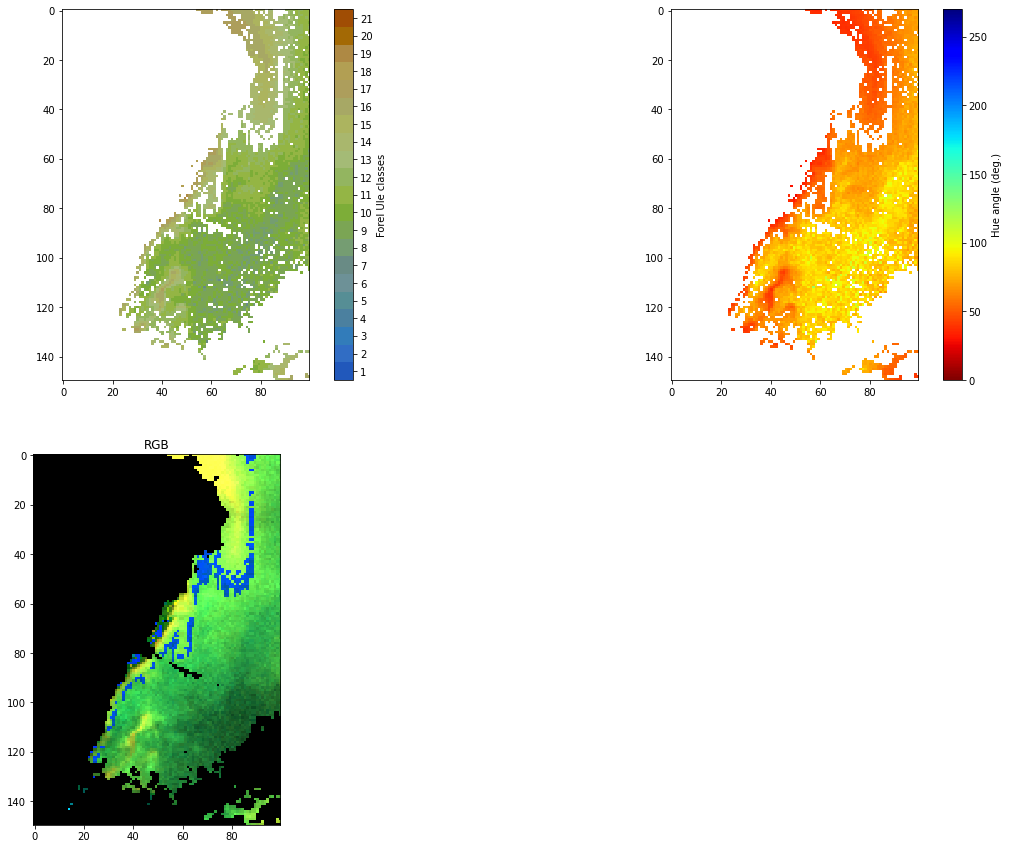

In [56]:
from importlib import reload
reload(fume)

fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(20,15))

rcextent=[100,250,50,150]
#rcextent=[100,150,100,150]
ax1,fu = plot_fu_image(axs[0,0],polymersmallfile,
                      reflectance_prefix='Rw',
                      sensorcorr='olci',
                      rcextent=rcextent)

ax2,ha = plot_ha_image(axs[0,1],polymersmallfile,
                      reflectance_prefix='Rw',
                      sensorcorr='olci',
                      rcextent=rcextent)

ax3 = plot_rgb_image(axs[1,0],polymersmallfile,
                    bands=bands_olci,
                    rcextent=rcextent)

plt.delaxes(axs[1,1])
ax3.set_title('RGB');

In [57]:
r,c=(rcextent[0]+45,rcextent[2]+68)
img = xr.open_dataset(polymersmallfile)
img.isel(height=r,width=c)
fu[45,68]

nan

## Other image files

### AQUA_MODIS.20060504T115501

# Liverpool Bay test: Polymer vs. Baseline AC

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(200, 250)
(196, 218)


Text(0.5, 1.0, 'RGB Baseline AC')

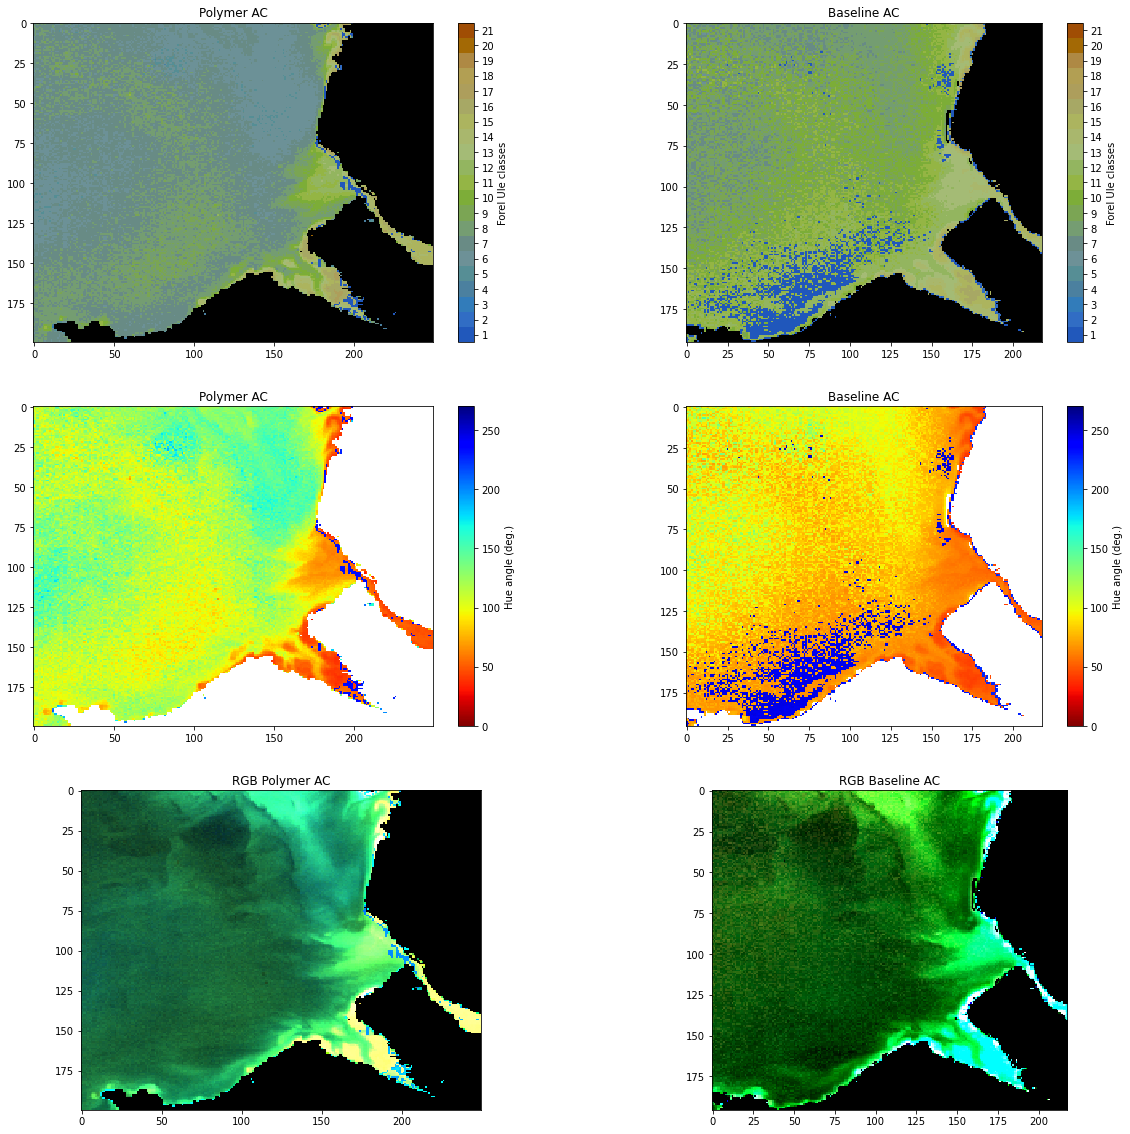

In [145]:
fig,axs = plt.subplots(nrows=3,ncols=2,figsize=(20,20))

ax1 = plot_fu_image(axs[0,0],'data/S3A_OL_20200506T104005_20200506T104305_20200507T143731_0179_058_051_1980_LN1_O_NT_002.polymer.LivBay.nc',
             reflectance_prefix='Rw',
             sensorcorr='olci',
             rcextent=[0,200,0,250])

ax2 = plot_fu_image(axs[0,1],'data/S3A_OL_2_WFR____20200506T104005_20200506T104305_20200507T211159_0179_058_051_1980_MAR_O_NT_002.LivBay.nc',
             reflectance_prefix='_reflectance',
             sensorcorr='olci',
             rcextent=[0,200,0,250])

ax1.set_title('Polymer AC')
ax2.set_title('Baseline AC')


ax3 = plot_ha_image(axs[1,0],'data/S3A_OL_20200506T104005_20200506T104305_20200507T143731_0179_058_051_1980_LN1_O_NT_002.polymer.LivBay.nc',
             reflectance_prefix='Rw',
             sensorcorr='olci',
             rcextent=[0,200,0,250])

ax4 = plot_ha_image(axs[1,1],'data/S3A_OL_2_WFR____20200506T104005_20200506T104305_20200507T211159_0179_058_051_1980_MAR_O_NT_002.LivBay.nc',
             reflectance_prefix='_reflectance',
             sensorcorr='olci',
             rcextent=[0,200,0,250])

ax3.set_title('Polymer AC')
ax4.set_title('Baseline AC')

ax5 = plot_rgb_image(axs[2,0],'data/S3A_OL_20200506T104005_20200506T104305_20200507T143731_0179_058_051_1980_LN1_O_NT_002.polymer.LivBay.nc',
             bands=bands_olci,
             rcextent=[0,200,0,250])

ax6 = plot_rgb_image(axs[2,1],'data/S3A_OL_2_WFR____20200506T104005_20200506T104305_20200507T211159_0179_058_051_1980_MAR_O_NT_002.LivBay.nc',
             bands=bands_olci_eumetsat,
             rcextent=[0,200,0,250])

ax5.set_title('RGB Polymer AC')
ax6.set_title('RGB Baseline AC')